In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
import gc
import numpy as np

from src.config import load_typed_config
from src.model.lvsm import LVSM, LVSMCfg
from src.model.model_wrapper import ModelWrapper
from src.model.lora.lora import add_lora, LoRAConfig

/usr/local/Caskroom/miniconda/base/envs/lvsm_251/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def reject_outliers(arr, iq_range=0.5):
    """
    Reject outliers from a NumPy array based on the interquantile range.
    """
    # Calculate the quantile range to drop from each tail.
    pcnt = (1 - iq_range) / 2

    # Compute the quantiles, ignoring NaNs.
    qlow = np.nanquantile(arr, pcnt)
    median = np.nanquantile(arr, 0.5)
    qhigh = np.nanquantile(arr, 1 - pcnt)

    # Compute the interquantile range.
    iqr = qhigh - qlow

    # Create a mask for values within the IQR range of the median.
    mask = np.abs(arr - median) <= iqr

    return arr[mask]

### Load the config and the model

In [4]:
models = {
    "full": {
        "name": r"LVSM$_{\text{base}}$",
        "checkpoint": "checkpoints/full_run_ft_epoch_96-step_100000.ckpt",
        "vae": False,
        "patch_size": 8,
        "experiment": "re10k",
    },
    "vae_4x4": {
        "name": r"LVSM$_{\text{vae}}$ ($4\times4$)",
        "checkpoint": "checkpoints/4x4-200k-epoch_193-step_200000.ckpt",
        "vae": True,
        "patch_size": 4,
        "experiment": "re10k_vae",
    },
    "vae_4x4_lora": {
        "name": r"LVSM$_{\text{vae}}$ ($4\times4$ / LoRA)",
        "checkpoint": "checkpoints/4x4-200k-vae-ft_epoch_18-step_18700.ckpt",
        "vae": True,
        "patch_size": 4,
        "experiment": "re10k_vae_ft",
    },
    "vae_6x6": {
        "name": r"LVSM$_{\text{vae}}$ ($6\times6$)",
        "checkpoint": "checkpoints/6x6-200k-epoch_193-step_200000.ckpt",
        "vae": True,
        "patch_size": 6,
        "experiment": "re10k_vae",
    },
    "vae_8x8": {
        "name": r"LVSM$_{\text{vae}}$ ($8\times8$)",
        "checkpoint": "checkpoints/8x8-r2-epoch_96-step_100000.ckpt",
        "vae": True,
        "patch_size": 8,
        "experiment": "re10k_vae",
    },
    "vae_24x24": {
        "name": r"LVSM$_{\text{vae}}$ ($24\times24$)",
        "checkpoint": "checkpoints/24x24-r1-epoch_96-step_100000.ckpt",
        "vae": True,
        "patch_size": 24,
        "experiment": "re10k_vae",
    },
}

torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_math_sdp(True)
torch.backends.cuda.enable_cudnn_sdp(True)
torch.backends.cuda.enable_mem_efficient_sdp(True)

device = "cuda" if torch.cuda.is_available() else "cpu"
sdpa_kernel = "torch-sdpa"
def load_model(*, name, checkpoint, vae, patch_size, experiment):
    print(f"Loading model {name}")
    with initialize(version_base=None, config_path="config"):
        cfg = compose("main", overrides=[f"+experiment={experiment}", f"lvsm_cfg.patch_size={patch_size}", f"lvsm_cfg.transformer_cfg.sdpa_kernel={sdpa_kernel}"])

    lvsm_cfg = load_typed_config(cfg["lvsm_cfg"], LVSMCfg)

    # Load model
    ckpt = torch.load(checkpoint, map_location=device)
    model = LVSM.from_cfg(lvsm_cfg)

    if experiment == "re10k_vae_ft":
        lora_cfg = load_typed_config(cfg["train"]["finetune_vae_decoder"], LoRAConfig)
        add_lora(model.vae.vae.decoder, lora_cfg)

        def ignore_lora_drouput_mask(module, incompatible_keys):            
            unexpected_keys = incompatible_keys.unexpected_keys
            for i in range(len(unexpected_keys) - 1, -1, -1):
                if unexpected_keys[i].endswith("lora_dropout_mask"):
                    key = unexpected_keys.pop(i)
                    print(f"[load_state_dict_post_hook] Ignored unexpected LoRA key: {key}")

        model.register_load_state_dict_post_hook(ignore_lora_drouput_mask)
            
            
    compile = False
    if compile:
        model = torch.compile(model)

    for old_key in list(ckpt["state_dict"].keys()):
        new_key = old_key.replace("model.", "")

        if compile:
            if not new_key.startswith("_orig_mod."):
                new_key = f"_orig_mod.{new_key}"
        else:
            new_key = new_key.replace("_orig_mod.", "")
        
        ckpt["state_dict"][new_key] = ckpt["state_dict"].pop(old_key)

    model.load_state_dict(ckpt["state_dict"])
    model.eval()

    return model

for model, model_params in models.items():
    models[model]["model"] = load_model(**model_params)

for model, model_params in models.items():
    models[model]["model"].to(device)

Loading model LVSM$_{\text{base}}$


/root/miniconda3/envs/lvsm_nightly/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning:

In 'main': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information



Loading model LVSM$_{\text{vae}}$ ($4\times4$)
Hugging Face model stabilityai/stable-diffusion-3.5-large is defined to be gated. Attempting to access the model with user [Kai Helli]...
Loading model LVSM$_{\text{vae}}$ ($4\times4$ / LoRA)
Hugging Face model stabilityai/stable-diffusion-3.5-large is defined to be gated. Attempting to access the model with user [Kai Helli]...
[load_state_dict_post_hook] Ignored unexpected LoRA key: vae.vae.decoder.conv_out.parametrizations.weight.0.lora_dropout_mask
[load_state_dict_post_hook] Ignored unexpected LoRA key: vae.vae.decoder.mid_block.resnets.1.conv2.parametrizations.weight.0.lora_dropout_mask
[load_state_dict_post_hook] Ignored unexpected LoRA key: vae.vae.decoder.mid_block.resnets.1.conv1.parametrizations.weight.0.lora_dropout_mask
[load_state_dict_post_hook] Ignored unexpected LoRA key: vae.vae.decoder.mid_block.resnets.0.conv2.parametrizations.weight.0.lora_dropout_mask
[load_state_dict_post_hook] Ignored unexpected LoRA key: vae.vae.dec

### Inference Time and Memory Evaluation

In [5]:
import torch
import matplotlib.pyplot as plt
from torch.profiler import profile, record_function, ProfilerActivity

##########################
# Setup and Data Creation
##########################

device = "cuda" if torch.cuda.is_available() else "cpu"
num_batch = 1
num_tgt = 1
img_size = 192
max_src = 16
num_iterations = 20

# Make random data sized for the maximum number of views
torch.manual_seed(42)

#############################
# Profiling Function
#############################
def profile_model(model, num_src, num_iterations, device):
    """
    Profiles the given model for num_src source views.
    Returns the average time (ms) and memory (MB) for the 'inference' block.
    """
    assert device == "cuda", "Only cuda supported for now"
    model.eval()
    
    # Unpack the preallocated tensors
    src_img = torch.randn(num_batch, num_src, 3, img_size, img_size).to(device)
    src_rays = torch.randn(num_batch, num_src, 6, img_size, img_size).to(device)
    tgt_rays = torch.randn(num_batch, num_tgt, 6, img_size, img_size).to(device)
    vae_latents = {
        "mean": torch.randn(num_batch, num_src, 16, 24, 24).to(device),
        "std": torch.randn(num_batch, num_src, 16, 24, 24).to(device)
    }
    
    # Build the attention mask for the current number of source views
    num_tkn_per_view = model.get_num_tkn_per_view(img_size, img_size)
    attn_mask = ModelWrapper._get_full_mask(num_src, num_tgt, num_tkn_per_view, device)
    
    # Run profiler
    with torch.no_grad(), torch.autocast(device_type=device, enabled=True, dtype=torch.bfloat16):
        memory_allocated = []
        elapsed_times = []
        # The first iteration is for warmup
        for i in range(num_iterations + 1):
            # Reset peak memory stats at the start of each iteration
            torch.cuda.reset_peak_memory_stats(device)

            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)
            
            start.record()
            ####### Start of timed code #######            
            _ = model(
                src_img,
                src_rays,
                tgt_rays,
                attn_mask,
                vae_latents=vae_latents,
                decode_latents=True,
                decoder_requires_grad=False
            )
            ####### End of timed code #######
            end.record()
            
            torch.cuda.synchronize()

            if i > 0:
                # Retrieve the time elapsed during this iteration (in ms)
                elapsed_times += [start.elapsed_time(end)]
                # print(start.elapsed_time(end))
                
                # Retrieve the peak memory allocated during this iteration (in bytes)
                memory_allocated += [torch.cuda.max_memory_reserved(device)]
            
            gc.collect()
            torch.cuda.empty_cache()

    elapsed_times = np.array(elapsed_times)
    memory_allocated = np.array(memory_allocated)

    #print(f"{elapsed_times=}")
    #print(f"{memory_allocated=}")
    
    # Remove outliers
    elapsed_times = reject_outliers(elapsed_times)
    memory_allocated = reject_outliers(memory_allocated)

    #print("--")
    #print(f"{elapsed_times=}")
    #print(f"{memory_allocated=}")
    
    avg_gpu_time_ms = elapsed_times.mean()
    avg_gpu_mem_mb = memory_allocated.mean() / (1024**2)

    return avg_gpu_time_ms, avg_gpu_mem_mb


##########################
# Example: Comparing Models
##########################

# Prepare a dictionary to hold profiling results
time_results = {name: [] for name in models.keys()}
mem_results = {name: [] for name in models.keys()}

num_src_values = range(1, max_src + 1)

# Profile each model for each number of source views
for model_name, model_attr in models.items():
    model = model_attr["model"]

    print(f"--- Profiling {model_name} ---")
    for n in num_src_values:
        avg_time_ms, avg_gpu_mem_mb = profile_model(
            model,
            num_src=n,
            num_iterations=num_iterations,
            device=device
        )
        time_results[model_name].append(avg_time_ms)
        mem_results[model_name].append(avg_gpu_mem_mb)
        print(f"  num_src={n}, avg_inference_time={avg_time_ms:.4f} ms, avg_mem={avg_gpu_mem_mb:.4f} MB")

        # Cleanup
        gc.collect()
        torch.cuda.empty_cache()

    print()

--- Profiling full ---
  num_src=1, avg_inference_time=5.1268 ms, avg_mem=2456.0000 MB
  num_src=2, avg_inference_time=6.1443 ms, avg_mem=2503.4000 MB
  num_src=3, avg_inference_time=8.2990 ms, avg_mem=2514.0000 MB
  num_src=4, avg_inference_time=11.2936 ms, avg_mem=2598.0000 MB
  num_src=5, avg_inference_time=12.3963 ms, avg_mem=2650.0000 MB
  num_src=6, avg_inference_time=17.0158 ms, avg_mem=2662.0000 MB
  num_src=7, avg_inference_time=17.6643 ms, avg_mem=2712.0000 MB
  num_src=8, avg_inference_time=21.5146 ms, avg_mem=2770.0000 MB
  num_src=9, avg_inference_time=27.6240 ms, avg_mem=2869.3000 MB
  num_src=10, avg_inference_time=35.1393 ms, avg_mem=2919.3000 MB
  num_src=11, avg_inference_time=37.1844 ms, avg_mem=3005.4000 MB
  num_src=12, avg_inference_time=43.0742 ms, avg_mem=3093.4000 MB
  num_src=13, avg_inference_time=48.7679 ms, avg_mem=3260.0000 MB
  num_src=14, avg_inference_time=49.4239 ms, avg_mem=3396.0000 MB
  num_src=15, avg_inference_time=54.7176 ms, avg_mem=3512.0000 MB

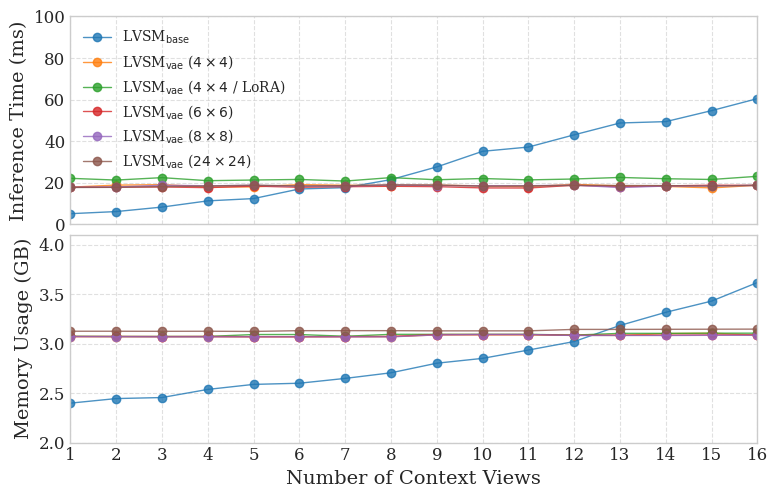

In [34]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 10,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'savefig.dpi': 300,
    'grid.linestyle': '--',
    'grid.alpha': 0.6
})

# Determine the x-axis range based on your num_src_values
x_min = int(np.min(num_src_values))
x_max = int(np.max(num_src_values))
x_ticks = np.arange(x_min, x_max + 1, 1)

# Combine both plots into a single figure with two vertically-stacked subplots sharing the same x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5.2))

# Plot Inference Time on the top subplot:
for idx, (model_key, model_params) in enumerate(models.items()):
    model_name = model_params["name"]
    x_values = np.array(num_src_values)
    ax1.plot(x_values, np.array(time_results[model_key]),
             label=model_name,
             marker='o',
             linewidth=1,
             markersize=6,
             alpha=0.8)
ax1.set_ylabel(r'Inference Time (ms)', fontsize=14)
ax1.set_ylim(bottom=0, top=100)
ax1.grid(True, which='both')
ax1.legend(loc='upper left')


# Plot Memory Usage on the bottom subplot:
for idx, (model_key, model_params) in enumerate(models.items()):
    model_name = model_params["name"]
    x_values = np.array(num_src_values)
    ax2.plot(x_values, np.array(mem_results[model_key])/1024,
             label=model_name,
             marker='o',
             linewidth=1,
             markersize=6,
             alpha=0.8)
ax2.set_xlabel(r'Number of Context Views', fontsize=14)
ax2.set_ylabel(r'Memory Usage (GB)', fontsize=14)
ax2.set_ylim(bottom=2, top=4.1)
ax2.grid(True, which='both')
#ax2.legend(loc='upper right')

# Configure shared x-axis
ax2.set_xticks(x_ticks)
ax2.set_xlim(x_min, x_max)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)
fig.savefig("eval_output/inference_resources.pdf", format="pdf")
plt.show()


### Training Time and Memory Evaluation

In [8]:
import torch
import matplotlib.pyplot as plt
from torch.profiler import profile, record_function, ProfilerActivity

##########################
# Setup and Data Creation
##########################

device = "cuda" if torch.cuda.is_available() else "cpu"
max_batch = 64
num_tgt = 6
img_size = 192
num_src = 2
num_iterations = 20

# Make random data sized for the maximum number of views
torch.manual_seed(42)


#############################
# Profiling Function
#############################
def profile_model(model, num_batch, num_iterations, device, vae, lora):
    """
    Profiles the given model for num_src source views.
    Returns the average time (ms) and memory (MB) for the 'inference' block.
    """
    assert device == "cuda", "Only cuda supported for now"
    model.train()
    
    src_img = torch.randn(num_batch, num_src, 3, img_size, img_size).to(device)
    src_rays = torch.randn(num_batch, num_src, 6, img_size, img_size).to(device)
    tgt_rays = torch.randn(num_batch, num_tgt, 6, img_size, img_size).to(device)
    vae_latents = {
        "mean": torch.randn(num_batch, num_src, 16, 24, 24).to(device),
        "std": torch.randn(num_batch, num_src, 16, 24, 24).to(device)
    }
    
    # Build the attention mask for the current number of source views
    num_tkn_per_view = model.get_num_tkn_per_view(img_size, img_size)
    attn_mask = ModelWrapper._get_full_mask(num_src, num_tgt, num_tkn_per_view, device)
    
    # Run profiler
    with torch.autocast(device_type=device, enabled=True, dtype=torch.bfloat16):

        memory_allocated = []
        elapsed_times = []
        # The first iteration is for warmup
        for i in range(num_iterations + 1):
            # Reset peak memory stats at the start of each iteration
            torch.cuda.reset_peak_memory_stats(device)

            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)
            
            start.record()
            ####### Start of timed code #######
            output, output_latents = model(
                src_img,
                src_rays,
                tgt_rays,
                attn_mask,
                vae_latents=vae_latents,
                decode_latents=False if not lora else True,
                decoder_requires_grad=False
            )

            # Compute a dummy loss from the output.
            # Replace this with your actual loss computation as needed.
            if vae:
                loss = output_latents.sum()
            else:
                loss = output.sum()
                
            # Backward pass (this computes gradients)
            loss.backward()
            ####### End of timed code #######
            end.record()
            
            torch.cuda.synchronize()

            if i > 0:
                # Retrieve the time elapsed during this iteration (in ms)
                elapsed_times += [start.elapsed_time(end)]
                # print(start.elapsed_time(end))
                
                # Retrieve the peak memory allocated during this iteration (in bytes)
                memory_allocated += [torch.cuda.max_memory_reserved(device)]
                
            model.zero_grad()
        
            gc.collect()
            torch.cuda.empty_cache()

    elapsed_times = np.array(elapsed_times)
    memory_allocated = np.array(memory_allocated)

    #print(f"{elapsed_times=}")
    #print(f"{memory_allocated=}")
    
    # Remove outliers
    elapsed_times = reject_outliers(elapsed_times)
    memory_allocated = reject_outliers(memory_allocated)

    #print("--")
    #print(f"{elapsed_times=}")
    #print(f"{memory_allocated=}")
    
    avg_gpu_time_ms = elapsed_times.mean()
    avg_gpu_mem_mb = memory_allocated.mean() / (1024**2)

    return avg_gpu_time_ms, avg_gpu_mem_mb

##########################
# Example: Comparing Models
##########################

# Prepare a dictionary to hold profiling results
batch_time_results = {name: [] for name in models.keys()}
batch_mem_results = {name: [] for name in models.keys()}

#num_batch_values = range(1, max_batch + 1)

num_batch_values = [1, 2, 4, 8, 16, 24, 32, 40, 48, 56, 64]

# Profile each model for each number of source views
for model_name, model_attr in models.items():
    model = model_attr["model"]
    vae = "vae" in model_attr["experiment"]
    lora = model_attr["experiment"] == "re10k_vae_ft"
    print(f"--- Profiling {model_name} ---")
    oom = False
    for n in num_batch_values:
        if oom:
            continue
            
        try:
            avg_time_ms, avg_gpu_mem_mb = profile_model(
                model,
                num_batch=n,
                num_iterations=num_iterations,
                device=device,
                vae=vae,
                lora=lora
            )
            gc.collect()
            torch.cuda.empty_cache()
        except torch.cuda.OutOfMemoryError:
            oom = True
            gc.collect()
            torch.cuda.empty_cache()
            continue
        
        batch_time_results[model_name].append(avg_time_ms)
        batch_mem_results[model_name].append(avg_gpu_mem_mb)
        print(f"  num_batch={n}, avg_inference_time={avg_time_ms:.4f} ms, avg_mem={avg_gpu_mem_mb:.4f} MB")
    print()

--- Profiling full ---
  num_batch=1, avg_inference_time=73.0873 ms, avg_mem=4714.0000 MB
  num_batch=2, avg_inference_time=138.7137 ms, avg_mem=6168.0000 MB
  num_batch=4, avg_inference_time=226.3837 ms, avg_mem=9029.5294 MB
  num_batch=8, avg_inference_time=418.3380 ms, avg_mem=14692.0000 MB
  num_batch=16, avg_inference_time=820.2725 ms, avg_mem=25994.0000 MB
  num_batch=24, avg_inference_time=1232.2455 ms, avg_mem=37082.0000 MB
  num_batch=32, avg_inference_time=1648.6573 ms, avg_mem=48488.0000 MB
  num_batch=40, avg_inference_time=2425.4407 ms, avg_mem=59946.0000 MB
  num_batch=48, avg_inference_time=3348.7355 ms, avg_mem=70996.0000 MB
  num_batch=56, avg_inference_time=4310.5078 ms, avg_mem=80435.9000 MB

--- Profiling vae_4x4 ---
  num_batch=1, avg_inference_time=35.7248 ms, avg_mem=3342.0000 MB
  num_batch=2, avg_inference_time=33.4755 ms, avg_mem=3386.0000 MB
  num_batch=4, avg_inference_time=32.6412 ms, avg_mem=3503.0000 MB
  num_batch=8, avg_inference_time=44.5027 ms, avg_me

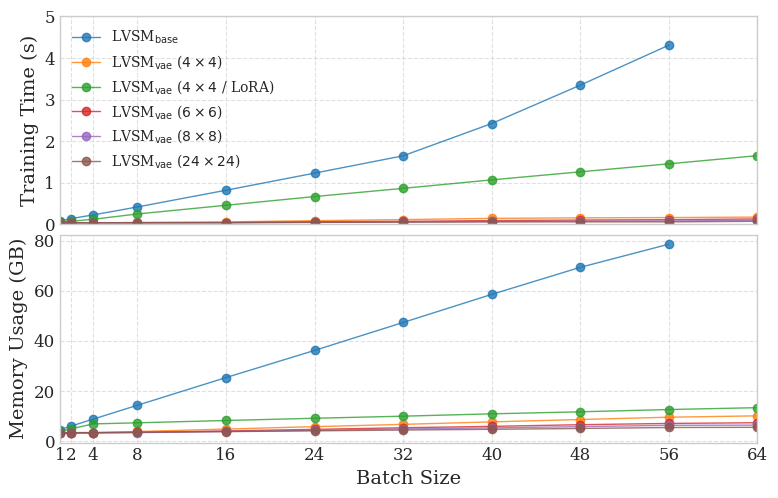

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 10,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'savefig.dpi': 300,
    'grid.linestyle': '--',
    'grid.alpha': 0.6
})

# Determine the x-axis range based on your num_src_values
x_min = int(np.min(num_batch_values))
x_max = int(np.max(num_batch_values))
x_ticks = num_batch_values #np.arange(x_min, x_max + 1, 1)

# Combine both plots into a single figure with two vertically-stacked subplots sharing the same x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5.2))

# Plot Inference Time on the top subplot:
for idx, (model_key, model_params) in enumerate(models.items()):
    model_name = model_params["name"]
    x_values = np.array(num_batch_values)[:len(batch_time_results[model_key])]
    ax1.plot(x_values, np.array(batch_time_results[model_key])/1e3,
             label=model_name,
             marker='o',
             linewidth=1,
             markersize=6,
             alpha=0.8)
#ax1.set_yscale("log")
#ax1.set_yticks([1, 10, 100, 1000])
#ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_ylabel(r'Memory Usage (GB)', fontsize=14)
ax1.set_ylabel(r'Training Time (s)', fontsize=14)
ax1.set_ylim(bottom=0, top=5)
ax1.grid(True, which='both')
ax1.legend(loc='upper left')

# Plot Memory Usage on the bottom subplot:
for idx, (model_key, model_params) in enumerate(models.items()):
    model_name = model_params["name"]
    x_values = np.array(num_batch_values)[:len(batch_mem_results[model_key])]
    ax2.plot(x_values, np.array(batch_mem_results[model_key])/1024,
             label=model_name,
             marker='o',
             linewidth=1,
             markersize=6,
             alpha=0.8)
#ax2.set_yscale("log")
#ax2.set_yticks([4, 8, 16, 32, 64])
#ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_ylabel(r'Memory Usage (GB)', fontsize=14)
ax2.set_xlabel(r'Batch Size', fontsize=14)
ax1.set_ylim(bottom=0)
ax2.grid(True, which='both')
#ax2.legend(loc='upper right')

# Configure shared x-axis
ax2.set_xticks(x_ticks)
ax2.set_xlim(x_min, x_max)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)
fig.savefig("eval_output/training_resources.pdf", format="pdf")
plt.show()


In [11]:
def get_x_y_dict(x_values, y_values):
    return {"x": x_values, "y": y_values}

torch.save(get_x_y_dict(num_src_values, mem_results), "eval_output/inference_resources_mem.pt")
torch.save(get_x_y_dict(num_src_values, time_results), "eval_output/inference_resources_time.pt")

torch.save(get_x_y_dict(num_batch_values, batch_mem_results), "eval_output/training_resources_mem.pt")
torch.save(get_x_y_dict(num_batch_values, batch_time_results), "eval_output/training_resources_time.pt")

In [3]:
# Load the dictionaries from the saved .pt files
inference_resources_mem = torch.load("eval_output/inference_resources_mem.pt", weights_only=False)
inference_resources_time = torch.load("eval_output/inference_resources_time.pt", weights_only=False)
training_resources_mem   = torch.load("eval_output/training_resources_mem.pt", weights_only=False)
training_resources_time  = torch.load("eval_output/training_resources_time.pt", weights_only=False)

# Restore the variables

num_src_values = inference_resources_mem["x"]
mem_results      = inference_resources_mem["y"]
time_results     = inference_resources_time["y"]
num_batch_values = training_resources_mem["x"]
batch_mem_results = training_resources_mem["y"]
batch_time_results = training_resources_time["y"]

# (Optional) Print to verify that everything loaded correctly
print("num_batch_values:", num_batch_values)
print("mem_results:", mem_results)
print("time_results:", time_results)
print("batch_mem_results:", batch_mem_results)
print("batch_time_results:", batch_time_results)


num_batch_values: [1, 2, 4, 8, 16, 24, 32, 40, 48, 56, 64]
mem_results: {'full': [2456.0, 2503.4, 2514.0, 2598.0, 2650.0, 2662.0, 2712.0, 2770.0, 2869.3, 2919.3, 3005.4, 3093.4, 3260.0, 3396.0, 3512.0, 3704.0], 'vae_4x4': [3144.0, 3144.0, 3144.0, 3144.0, 3142.0, 3142.0, 3144.8, 3144.0, 3162.0, 3163.0, 3163.0, 3158.0, 3156.9, 3176.0, 3180.0, 3160.0], 'vae_4x4_lora': [3148.0, 3146.0, 3146.0, 3146.0, 3166.0, 3166.0, 3148.0, 3168.0, 3168.0, 3168.0, 3168.0, 3160.0, 3178.0, 3178.0, 3180.0, 3180.0], 'vae_6x6': [3146.0, 3146.0, 3145.0, 3146.0, 3144.0, 3144.0, 3144.0, 3146.0, 3166.0, 3166.0, 3166.0, 3158.0, 3158.6, 3159.0, 3162.0, 3162.0], 'vae_8x8': [3144.0, 3144.0, 3142.0, 3142.0, 3142.0, 3142.0, 3142.0, 3142.0, 3162.0, 3166.0, 3166.0, 3156.0, 3156.0, 3156.0, 3158.0, 3158.6], 'vae_24x24': [3200.0, 3200.0, 3199.2, 3200.0, 3198.0, 3206.0, 3206.0, 3206.0, 3204.0, 3204.0, 3204.0, 3219.0, 3219.0, 3220.0, 3221.0, 3222.0]}
time_results: {'full': [5.126806595746209, 6.144273058573405, 8.2989737828572

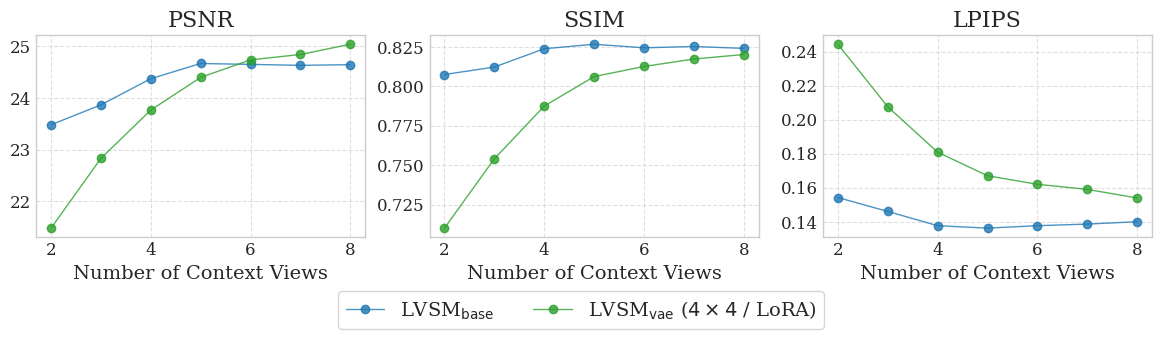

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Use the provided style settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'savefig.dpi': 300,
    'grid.linestyle': '--',
    'grid.alpha': 0.6
})

# Define the x-axis values
num_src = [2, 3, 4, 5, 6, 7, 8]

# Organize the data into a dictionary for easier plotting and legend management.
performances = {
    "model_a": {
        "name": r"LVSM$_{\text{base}}$",
        "psnr": [23.480610356186375, 23.866545128099848, 24.37404320456765, 24.667772466486152, 24.650622338959664, 24.632012396147758, 24.645158131917317],
        "ssim": [0.8074100378787878, 0.8121448863636364, 0.8237452651515151, 0.8265861742424242, 0.8243371212121212, 0.8251657196969697, 0.8239820075757576],
        "lpips": [0.15422289299242425, 0.14604048295454544, 0.1376657196969697, 0.13624526515151514, 0.1376657196969697, 0.1386126893939394, 0.14000355113636365],
        "color": "C0"
    },
    "model_b": {
        "name": r"LVSM$_{\text{vae}}$ ($4\times4$ / LoRA)",
        "psnr": [21.478627233794242, 22.830755898446746, 23.76575082721132, 24.39931360880534, 24.738095023415305, 24.842648072676226, 25.040739464037348],
        "ssim": [0.7101089015151515, 0.7540246212121212, 0.787405303030303, 0.8061079545454546, 0.8125, 0.8172348484848485, 0.8200757575757576],
        "lpips": [0.24431818181818182, 0.20756392045454544, 0.18087121212121213, 0.1670217803030303, 0.16199100378787878, 0.15901692708333334, 0.15394176136363635],
        "color": "C2"
    }
}

# Create three subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

# Define markers and line settings for consistency
marker_style = 'o'
line_width = 1
alpha_val = 0.8

# Prepare an empty list to collect line handles for a single, common legend
legend_handles = []

# Plot PSNR in the first subplot
ax = axes[0]
for key, model in performances.items():
    line, = ax.plot(num_src, model["psnr"],
                    marker=marker_style,
                    linewidth=line_width,
                    markersize=6,
                    alpha=alpha_val,
                    color=model["color"],
                    label=model["name"])
    # Only store one handle per model for the common legend
    legend_handles.append(line)
ax.set_xlabel("Number of Context Views")
ax.set_title("PSNR")
ax.grid(True)

# Plot SSIM in the second subplot
ax = axes[1]
for key, model in performances.items():
    ax.plot(num_src, model["ssim"],
            marker=marker_style,
            linewidth=line_width,
            markersize=6,
            alpha=alpha_val,
            color=model["color"],
            label=model["name"])
ax.set_xlabel("Number of Context Views")
ax.set_title("SSIM")
ax.grid(True)

# Plot LPIPS in the third subplot
ax = axes[2]
for key, model in performances.items():
    ax.plot(num_src, model["lpips"],
            marker=marker_style,
            linewidth=line_width,
            markersize=6,
            alpha=alpha_val,
            color=model["color"],
            label=model["name"])
ax.set_xlabel("Number of Context Views")
ax.set_title("LPIPS")
ax.grid(True)

# Create one common legend for all subplots.
# The legend is placed at the top center of the figure (adjust as needed).
fig.legend(handles=legend_handles, loc='lower center', ncol=len(performances), frameon=True)

# Adjust layout to reduce distances between subplots
fig.tight_layout(rect=[0, 0.1, 1, 1])  # leave space at the top for the legend

fig.subplots_adjust(wspace=0.195)

# Save and show the plot
plt.savefig("eval_output/experiment.pdf", format="pdf")
plt.show()